region
bj    50938.967213
cd    11188.704918
cq     8901.327869
cs     8471.557377
dl    11594.393443
gz    24839.426230
hf    12124.622951
hz    23364.688525
jn    13759.295082
nj    22921.573770
qd    16743.885246
sh    42891.163934
sy     7977.868852
sz    44705.918033
tj    20389.672131
wh    13648.672131
xm    34202.852459
yt     9118.754098
zz    12292.540984
Name: 供给(元/㎡), dtype: float64
#####全国加权平均：供给(元/㎡)#####
            供给(万元/㎡)
2014-03-01  1.774414
2014-04-01  2.143239
2014-05-01  2.311814
2014-06-01  2.143517
2014-07-01  2.112201
...              ...
2018-11-01  3.227862
2018-12-01  3.302040
2019-01-01  3.481083
2019-02-01  3.409391
2019-03-01  3.409158

[61 rows x 1 columns]


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

最优模型:                             Statespace Model Results                           
Dep. Variable:               供给(万元/㎡)   No. Observations:                   61
Model:               SARIMAX(4, 1, 2)   Log Likelihood                  52.703
Date:                Thu, 09 Apr 2020   AIC                            -91.405
Time:                        13:03:53   BIC                            -77.228
Sample:                    03-01-2014   HQIC                           -85.909
                         - 03-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3099      0.198      1.568      0.117      -0.078       0.697
ar.L2         -0.5784      0.183     -3.163      0.002      -0.937      -0.220
ar.L3         -0.3783      0.135     -2.800  

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27818 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_

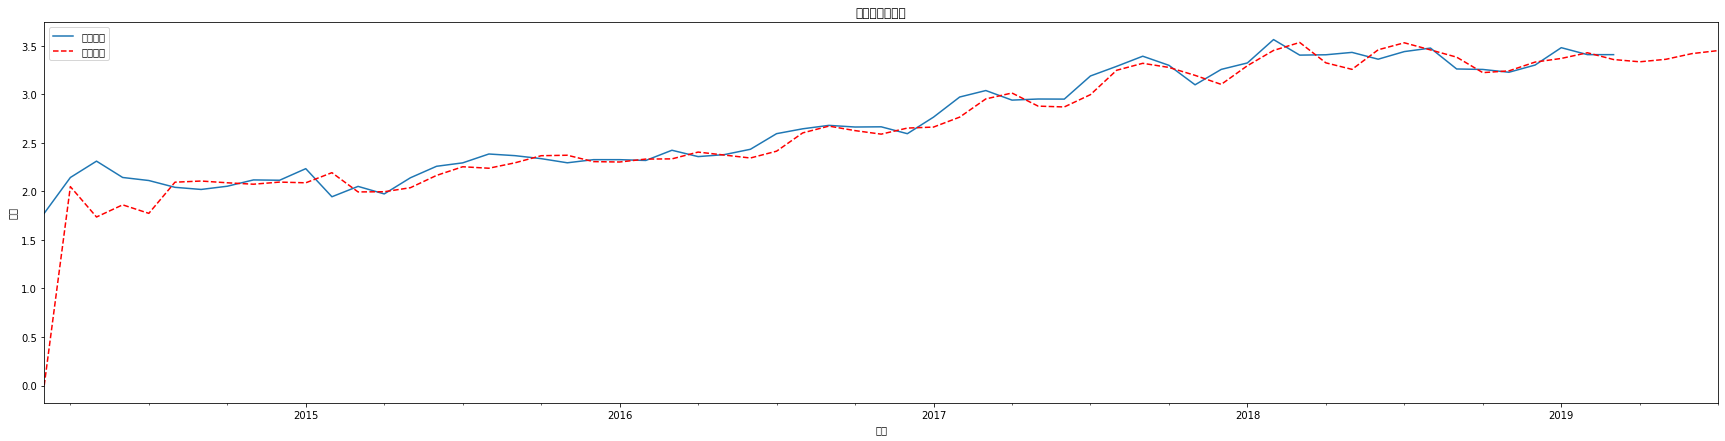

In [37]:
# -*- coding: utf-8 -*-
# 全国房价走势预测，使用时间序列ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

##Step1. Read file and combine tabs into one dataframe
file_path = '/content/drive/My Drive/Colab Notebooks/datasets/housing_prices.xlsx'

df = pd.DataFrame()
sheet_names = pd.ExcelFile(file_path).sheet_names
for sheet_name in sheet_names:
  region_df = pd.read_excel(file_path, sheet_name=sheet_name)
  region_df['region'] = sheet_name
  region_df['总价值（供给）'] = region_df['供给(万元)'] * region_df['供给(套)'] #计算各地区总供给价值
  region_df['总面积（供给）'] = region_df['供给(㎡)'] * region_df['供给(套)'] #计算各地区总供给面积
  region_df['region'] = sheet_name #将各地区缩写加入column
  df = pd.concat([df, region_df], ignore_index=True)
# print(df.info())

#地区均价
print(df.groupby('region')['供给(元/㎡)'].mean())

#全国加权平均
print('#####全国加权平均：供给(元/㎡)#####')
df_country = df.groupby('时间(年-月)')['总价值（供给）'].sum() / df.groupby('时间(年-月)')['总面积（供给）'].sum()
df_country = df_country.to_frame(name='供给(万元/㎡)')
df_country.index = pd.DatetimeIndex(df_country.index.values,
                               freq=df_country.index.inferred_freq)
print(df_country)

##Step2. Use ARIMA for modelling
# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)

# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        #model = ARIMA(df_month.Price,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(df_country['供给(万元/㎡)'],
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                ).fit(max_iter=2000)

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())
# print(results)


# ## Step3: Graph future prediction
# # 添加未来要预测的3个月
future_predict_month = 3
future = pd.DataFrame(best_model.get_prediction(start=0, end=len(df_country)+future_predict_month).predicted_mean,columns=['forecast'])
df_plt = future.merge(df_country,how='left',left_index=True,right_index=True)
print(df_plt)

# # # 沪市指数预测结果显示
plt.figure(figsize=(30,7))
df_plt['供给(万元/㎡)'].plot(label='实际指数')
df_plt.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('沪市指数（月）')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()